<ipython-input-3-8fa671b9db41>:88: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  plt.tight_layout() # Ensure everything fits


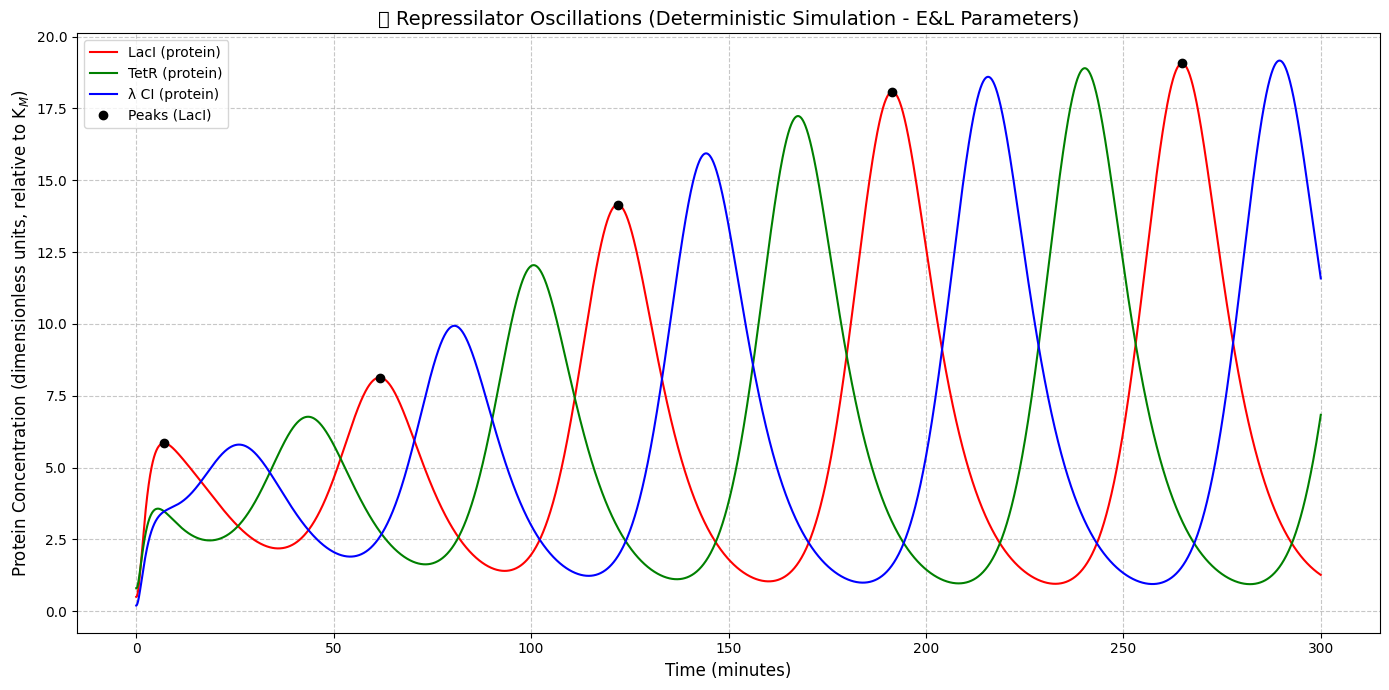

 Oscillation period (LacI): 64.46 ± 7.44 minutes (based on 4 cycles)
 Peak amplitudes (LacI): Min=5.85, Max=19.07, Mean=13.06


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

#  Repressilator system of ODEs (closer to Elowitz & Leibler Box 1)
def repressilator(t, y, alpha, alpha_0, beta, n):
    m1, p1, m2, p2, m3, p3 = y
    # mRNA equations are scaled such that the degradation term is -m_i
    # Protein equations are dp_i/dt = -beta * p_i + beta * m_i
    # (assuming m_i is scaled by translation efficiency and K_M for protein conc.)
    # Or, if m_i is just mRNA and p_i is protein, then dp_i/dt = -beta_actual*p_i + k_translation*m_i
     dp_i/dt = -beta * (p_i - m_i) implies m_i is a stand-in for protein production rate from mRNA
    # paper's Box 1 formulation:
    dm1 = -m1 + alpha / (1 + p3**n) + alpha_0  # LacI mRNA, repressed by CI
    dp1 = -beta * (p1 - m1)                    # LacI protein
    dm2 = -m2 + alpha / (1 + p1**n) + alpha_0  # TetR mRNA, repressed by LacI
    dp2 = -beta * (p2 - m2)                    # TetR protein
    dm3 = -m3 + alpha / (1 + p2**n) + alpha_0  # CI mRNA, repressed by TetR
    dp3 = -beta * (p3 - m3)                    # CI protein
    return [dm1, dp1, dm2, dp2, dm3, dp3]

#  Parameters 
# mRNA half-life = 2 min (this is our time unit for the dimensionless 't' in ODEs)
# Protein half-life = 10 min
beta = 0.2      # Protein:mRNA degradation rate ratio = (ln(2)/10) / (ln(2)/2) = 2/10 = 0.2
n = 2           # Hill coefficient (as in paper)

# alpha and alpha_0 are dimensionless production rates.
# Paper's Fig 1c caption: max rate 0.5 transcripts/s, repressed rate 5e-4 transcripts/s.
# Ratio is 1/1000. So alpha_0 approx alpha * 0.001
# The value of 'alpha' will affect amplitude. Let's try a value that gives oscillations.
# The paper's stability diagram (Fig 1b) suggests alpha (x K_M) should be > ~10 for oscillations with beta=0.2, n=2.
# If K_M is 40 (as per paper), and protein concentrations are what's plotted in their Fig 1c,
# then alpha in Box 1 units (related to protein production potential) could be larger.
# Let's test alpha values. A moderate alpha is needed to get reasonable amplitudes in dimensionless units.
alpha = 50      # Dimensionless maximum transcription rate.
alpha_0 = alpha * 0.001 # Basal (leaky) transcription rate

# Asymmetric initial conditions to help oscillations start
# These are dimensionless concentrations, relative to K_M for proteins.
y0 = [0.1, 0.5, 0.2, 0.8, 0.3, 0.2]  # [mLacI, pLacI, mTetR, pTetR, mCI, pCI]

# Time span for simulation
# The period will be longer with beta=0.2. Let's increase simulation time.
# One dimensionless time unit corresponds to an mRNA lifetime (approx 2min / ln(2) = ~2.88 min)
# Or if time is rescaled in units of mRNA lifetime (as stated in box 1), then 1 unit of t = 2 min
# Let's simulate for a longer duration to see established oscillations.
# If experimental period is ~160 min, we need dimensionless time of ~80.
t_final_dimensionless = 150 # dimensionless time units
tau = np.linspace(0, t_final_dimensionless, 4000)

# Solve the system
sol = solve_ivp(repressilator, (tau[0], tau[-1]), y0, args=(alpha, alpha_0, beta, n),
                t_eval=tau, method='RK45', rtol=1e-6, atol=1e-9) # Added atol for stability

#  Convert dimensionless time tau to minutes
# Box 1: "Time is rescaled in units of the mRNA lifetime"
# mRNA half-life = 2 min. mRNA lifetime = half-life / ln(2) approx 2.88 min.
# OR, if they mean the ODE time unit is such that the degradation term is -m (i.e., k_mRNA = 1),
# then 1 unit of dimensionless time = actual mRNA lifetime.
# The paper's Fig 1c caption gives mRNA half-life of 2 min.
# If the ODEs are scaled such that mRNA decay rate is 1, then one unit of dimensionless time
# corresponds to the mRNA mean lifetime (which is half-life / ln(2)).
# However, often in these models, for simplicity, "mRNA lifetime" is used loosely to mean half-life
# especially when converting back.
# Let's use the interpretation that 1 unit of dimensionless ODE time = 2 minutes (mRNA half-life, as per common convention in these plots)
# This matches the scaling used in many repressilator model interpretations.
time_minutes = sol.t * 2

# Plotting the protein oscillations
plt.figure(figsize=(14, 7)) # Adjusted figure size for better visibility
plt.plot(time_minutes, sol.y[1], 'r-', label='LacI (protein)')
plt.plot(time_minutes, sol.y[3], 'g-', label='TetR (protein)')
plt.plot(time_minutes, sol.y[5], 'b-', label='λ CI (protein)')

# Detect and mark peaks for LacI
# Adjust prominence based on typical amplitude. With alpha=50, beta=0.2, amplitudes might be higher.
peaks, properties = find_peaks(sol.y[1], prominence=1, distance=50) # distance helps avoid multiple close peaks
plt.plot(time_minutes[peaks], sol.y[1][peaks], 'ko', label='Peaks (LacI)')

# Styling
plt.xlabel('Time (minutes)', fontsize=12)
plt.ylabel('Protein Concentration (dimensionless units, relative to K$_M$)', fontsize=12)
plt.title(' Repressilator Oscillations (Deterministic Simulation - E&L Parameters)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout() # Ensure everything fits
plt.show()

#  Calculate and print the period
if len(peaks) > 1:
    periods = np.diff(time_minutes[peaks])
    mean_period = np.mean(periods)
    std_period = np.std(periods)
    print(f"Oscillation period (LacI): {mean_period:.2f} ± {std_period:.2f} minutes (based on {len(periods)} cycles)")
    # print(f"   Individual peak times: {time_minutes[peaks]}")
    # print(f"   Individual periods: {periods}")

    # Check amplitude stability
    peak_amplitudes = sol.y[1][peaks]
    print(f"Peak amplitudes (LacI): Min={np.min(peak_amplitudes):.2f}, Max={np.max(peak_amplitudes):.2f}, Mean={np.mean(peak_amplitudes):.2f}")

else:
    print(" Fewer than 2 peaks detected for LacI. Try increasing simulation time, adjusting find_peaks parameters, or checking model parameters.")

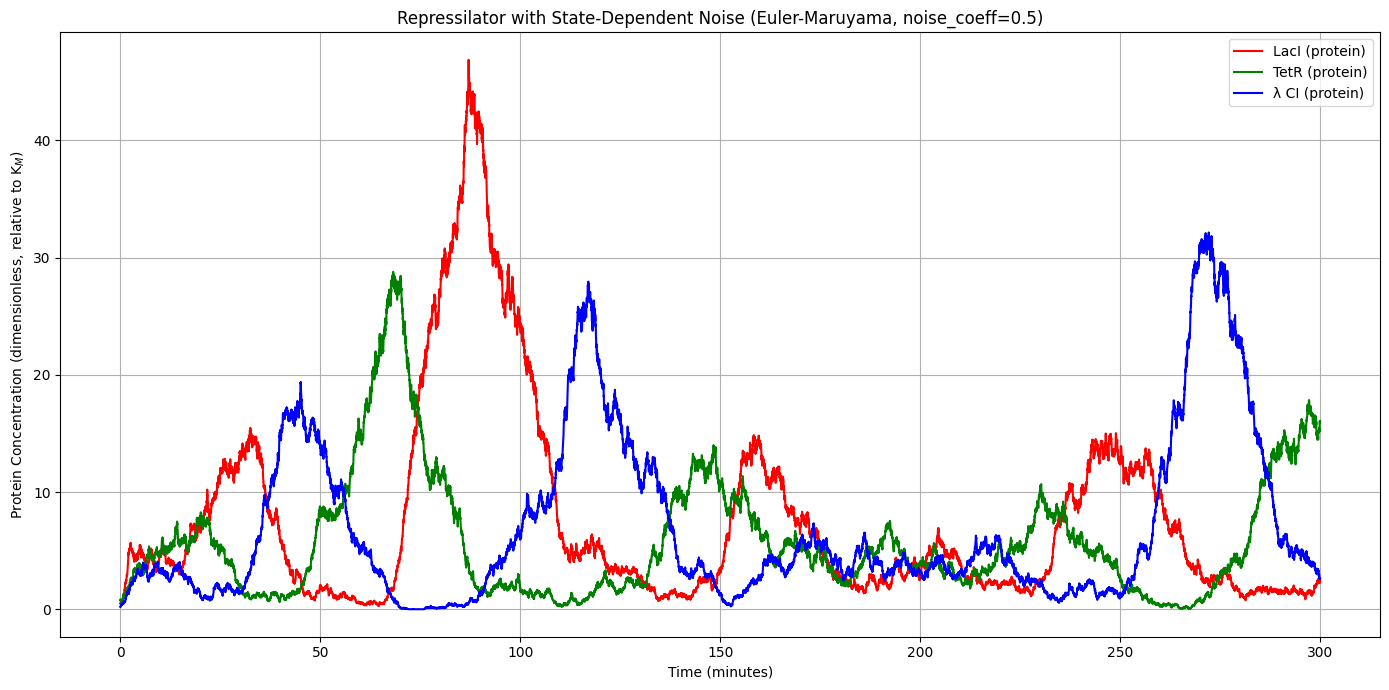

 LacI Oscillation Stats:
   Mean Period: 54.11 ± 10.66 min (based on 4 cycles)
   Mean Peak Amplitude: 19.83 ± 13.89


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Parameters (attempting to match Elowitz & Leibler, Nature 2000, Box 1 and Fig 1c context)
beta = 0.2      # Protein:mRNA degradation rate ratio
n = 2           # Hill coefficient
alpha = 50      # Dimensionless maximum transcription rate.
alpha_0 = alpha * 0.001 # Basal (leaky) transcription rate

# Noise parameter
# For state-dependent noise, noise_coeff will be multiplied by sqrt(state)
# For simple additive noise (as before), noise_coeff would be the 'noise_strength'
noise_coeff = 0.5   # Coefficient for the state-dependent noise term. TWEAK THIS.
                    # A higher value means more noise.
                    # Start with a moderate value and adjust to see qualitative effects.

# Time settings
t0_minutes, tf_minutes = 0, 300  # Simulate for 300 minutes
# If 1 unit of dimensionless time = 2 minutes (mRNA half-life)
# tf_dimensionless = tf_minutes / 2
# dt_dimensionless = 0.01 (small step for Euler-Maruyama)
dt_dimensionless = 0.01 # This is dt for the dimensionless ODEs
t_dimensionless = np.arange(0, tf_minutes / 2, dt_dimensionless)

# Initial conditions [m1, p1, m2, p2, m3, p3] - dimensionless
y = np.zeros((6, len(t_dimensionless)))
# Asymmetric initial conditions
y[:, 0] = [0.1, 0.5, 0.2, 0.8, 0.3, 0.2]

# Euler-Maruyama loop (ODE + State-Dependent Noise)
for i in range(1, len(t_dimensionless)):
    m1, p1, m2, p2, m3, p3 = y[:, i-1]

    # Ensure proteins are not negative for sqrt - apply a floor
    p1_eff = max(0, p1)
    p2_eff = max(0, p2)
    p3_eff = max(0, p3)

    # Deterministic part (using effective protein concentrations for repression)
    dm1_dt = -m1 + alpha / (1 + p3_eff**n) + alpha_0
    dp1_dt = -beta * (p1 - m1)
    dm2_dt = -m2 + alpha / (1 + p1_eff**n) + alpha_0
    dp2_dt = -beta * (p2 - m2)
    dm3_dt = -m3 + alpha / (1 + p2_eff**n) + alpha_0
    dp3_dt = -beta * (p3 - m3)

    # Stochastic part (noise proportional to sqrt(protein_concentration) * dW)
    # dW is N(0, sqrt(dt_dimensionless)) - here it's N(0,1)*sqrt(dt_dimensionless)
    dW1 = np.random.normal(0, 1) * np.sqrt(dt_dimensionless)
    dW2 = np.random.normal(0, 1) * np.sqrt(dt_dimensionless)
    dW3 = np.random.normal(0, 1) * np.sqrt(dt_dimensionless)

    # Update mRNAs (deterministic)
    y[0, i] = m1 + dm1_dt * dt_dimensionless
    y[2, i] = m2 + dm2_dt * dt_dimensionless
    y[4, i] = m3 + dm3_dt * dt_dimensionless

    # Update Proteins (with state-dependent noise on protein levels)
    # Noise term: noise_coeff * sqrt(current_protein_level_for_that_reaction_type) * dW
    # For simplicity, let's assume noise affects the protein levels directly
    # More accurately, noise terms in CLE come from each reaction's propensity.
    # This is an approximation:
    y[1, i] = p1 + dp1_dt * dt_dimensionless + noise_coeff * np.sqrt(p1_eff) * dW1
    y[3, i] = p2 + dp2_dt * dt_dimensionless + noise_coeff * np.sqrt(p2_eff) * dW2
    y[5, i] = p3 + dp3_dt * dt_dimensionless + noise_coeff * np.sqrt(p3_eff) * dW3

    # Ensure non-negativity after update (simple reflection or floor)
    y[1, i] = max(0, y[1, i])
    y[3, i] = max(0, y[3, i])
    y[5, i] = max(0, y[5, i])


# Time in minutes
time_minutes = t_dimensionless * 2

# Plotting
plt.figure(figsize=(14,7))
plt.plot(time_minutes, y[1], 'r-', label='LacI (protein)')
plt.plot(time_minutes, y[3], 'g-', label='TetR (protein)')
plt.plot(time_minutes, y[5], 'b-', label='λ CI (protein)')
plt.xlabel('Time (minutes)')
plt.ylabel('Protein Concentration (dimensionless, relative to K$_M$)')
plt.title(f'Repressilator with State-Dependent Noise (Euler-Maruyama, noise_coeff={noise_coeff})')
plt.grid(True)
plt.legend()
plt.ylim(bottom=-max(y[1].max(), y[3].max(), y[5].max())*0.05) # Ensure 0 is visible
plt.tight_layout()
plt.show()

# Basic Peaks detection (might need more robust for noisy data)
# Adjust prominence based on noise level and typical amplitude
peaks_lacI, _ = find_peaks(y[1], prominence=np.std(y[1])/2, distance=int(20 / (2*dt_dimensionless)) ) # Min dist ~20 mins

if len(peaks_lacI) > 1:
    periods_lacI = np.diff(time_minutes[peaks_lacI])
    mean_period_lacI = np.mean(periods_lacI)
    std_period_lacI = np.std(periods_lacI)
    print(f" LacI Oscillation Stats:")
    print(f"   Mean Period: {mean_period_lacI:.2f} ± {std_period_lacI:.2f} min (based on {len(periods_lacI)} cycles)")
    peak_amps_lacI = y[1][peaks_lacI]
    print(f"   Mean Peak Amplitude: {np.mean(peak_amps_lacI):.2f} ± {np.std(peak_amps_lacI):.2f}")
else:
    print(" LacI oscillations not clear enough for period analysis with current peak settings.")